In [121]:
!pip install my_utils

In [122]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

#The Stem

###Reading the Dataset and Creating the Dataloaders

In [123]:
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* In the output of the code below, 256 corresponds to the batch size.
* 28x28 corresponds to the dimensions (HxW) of an image.
* `y` contains the training data, with each sample having a labelled class (0-9.)

In [124]:
X, y = next(iter(train_iter)) #first batch
print(X.size())
print(y)
print(y.size())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 1, 28, 28])
tensor([9, 3, 8, 8, 0, 7, 3, 8, 7, 0, 9, 3, 4, 1, 8, 9, 5, 8, 4, 0, 6, 9, 5, 8,
        1, 9, 4, 0, 3, 2, 6, 3, 3, 3, 3, 4, 4, 8, 1, 6, 9, 6, 2, 3, 1, 0, 6, 1,
        3, 1, 7, 5, 7, 9, 3, 3, 4, 0, 4, 9, 5, 9, 4, 7, 0, 5, 2, 2, 8, 0, 6, 4,
        7, 3, 4, 0, 7, 8, 0, 3, 0, 8, 3, 3, 5, 4, 0, 1, 6, 0, 2, 6, 1, 7, 6, 0,
        5, 2, 2, 1, 2, 7, 3, 8, 3, 4, 3, 2, 5, 3, 5, 8, 7, 1, 2, 3, 8, 0, 8, 1,
        3, 2, 8, 9, 5, 8, 7, 7, 0, 4, 5, 8, 5, 2, 8, 4, 6, 7, 2, 7, 6, 3, 4, 3,
        4, 7, 3, 1, 1, 4, 6, 6, 6, 3, 4, 7, 1, 8, 3, 5, 7, 6, 2, 1, 9, 2, 5, 5,
        3, 1, 4, 6, 9, 9, 6, 4, 0, 4, 5, 8, 0, 9, 2, 0, 0, 3, 7, 8, 3, 7, 4, 8,
        9, 6, 7, 7, 3, 7, 6, 7, 0, 9, 1, 3, 9, 7, 1, 5, 2, 9, 4, 0, 7, 3, 6, 7,
        1, 2, 6, 0, 5, 7, 2, 4, 8, 0, 1, 0, 6, 3, 6, 5, 4, 7, 0, 7, 5, 7, 5, 3,
        1, 4, 3, 7, 0, 3, 1, 6, 9, 9, 5, 9, 6, 2, 8, 5])
torch.Size([256])


###Dividing an Image into Patches

* The output of the code below - `X` - is a matrix which contains feature vectors for each patch.

In [125]:
size = 14 #patch size - also try 7x7 and 4x4
stride = 4 #patch stride
#X = torch.range(1, 28*28)
#X = train_iter
X, y = next(iter(train_iter))
X = X.view(-1, 28, 28)
X = X.unfold(1, size, stride).unfold(2, size, stride)
X = torch.flatten(X, start_dim=3)
X = X.view(-1, 16, 49)
#print(X.size())
print(X[:, 0])
X[0].shape

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0078, 0.0000,  ..., 0.8667, 0.8275, 0.7020]])


torch.Size([16, 49])

#The Backbone

###Model Definition and Parameter Initialisation

* The model - `Net` - is defined below. It contains two linear layers, making it a multi-layer perceptron.
* Of the number of hidden layers experimented with, 256 gives the highest accuracy.
* As input, the first layer - `self.Linear1` - takes 784 (28x28) features. It then outputs 256 (16x16) features, which are used as the input to the second layer - `self.Linear2`.
* Finally, the second layer ouputs 10 features - 10 corresponding to the number of classes in the dataset. 
* `nn.ReLU()`, a nonlinear activation function, is found to return the highest accuracy.
 Sigmoid and Tanh were also experimented with but gave lower accuracies.

In [126]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, num_hidden)
        self.Linear2 = nn.Linear(num_hidden, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, self.num_inputs)
        x = self.Linear1(x)
        x = self.relu(x)
        out = self.Linear2(x)
        return out

In [127]:
num_inputs, num_hidden, num_outputs = 784, 256, 10
net = Net(num_inputs, num_hidden, num_outputs)
print(net)

Net(
  (Linear1): Linear(in_features=784, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


* The parameters - weights and bias - are initialised below.
* A default initialisation method - `torch.nn.init.normal_` - is used because it...
* Other methods Xavier and He - `torch.nn.init.xavier_normal_` and `torch.nn.init.kaiming_normal_` - were also experimented with but returned lower accuracies.
* The `if` function below enables different linear layers to be intialised in different ways.

In [128]:
def init_weights(m):
    if isinstance(m, nn.Linear): 
        torch.nn.init.normal_(m.weight, std=0.01) 
        torch.nn.init.zeros_(m.bias)

net.apply(init_weights);
print(net)

Net(
  (Linear1): Linear(in_features=784, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


In [129]:
net = Net(num_inputs, num_hidden, num_outputs)

#The Classifier

###Loss Function, Optimisation Algorithm and Regularisation

* Softmax cross-entropy - `nn.CrossEntropyLoss()` - is used as the loss function.
* Mean squared error loss - `nn.MSELoss()` - is also experimented with as a loss function but it returns a lower accuracy.
* Minibatch SGD - `torch.optim.SGD` - with a learning rate of 0.05 is used as the opimisation algorithm.
* Of the values experimented with for the learning rate, 0.05 returns the highest accuracy.
* Weight decay is used as the  regularisation technique. Of the values experimented with, 0.0005 returns the highest accuracy.
* Dropout was also experimented with but returned lower accuracies. 
* For dropout, the following values for the probability of an element to be zeroed were experimented with: 0.2, 0.5 (default) and 0.8. Of these values, 0.2 returned the highest accuracy.

In [130]:
loss = nn.CrossEntropyLoss()
lr, wd = 0.05, 0.0005 

optimiser = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

###Evaluation

* The `accuracy` function below computes the number of correct predictions that the model makes.
* `y_hat` is a matrix, the second dimension of which stores prediction scores for each class.

In [131]:
def accuracy(y_hat, y):  
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)          
    cmp = (y_hat.type(y.dtype) == y)  
    return float(torch.sum(cmp)) 

* The class below is used to accumulate sums over a given number of variables.

In [132]:
class Accumulator:  
    def __init__(self, n):
        self.data = [0.0] * n 
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

* Finally, the function below computes the accuracy.

In [133]:
def evaluate_accuracy(net, data_iter): 
    metric = Accumulator(2)  
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

###Training

* Below, a function is defined to train a single epoch.
* First the model is set to training mode, then the gradients are computed and the parameters are updated and finally the training loss and accuracy are returned.

In [134]:
def train_epoch_ch3(net, train_iter, loss, optimiser, batch_size=256, num_outputs=10):  
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimiser.zero_grad()
        l.backward()
        optimiser.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    return metric[0] / metric[2], metric[1] / metric[2]

* The class below is used to incrementally plot training loss, training accuracy and test accuracy for each epoch.

In [135]:
class Animator:  
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y):
            y = [y]
        n = len(y)
        if not hasattr(x):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

* The function below trains the model.

In [136]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimiser): 
    animator = Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0.1, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimiser)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

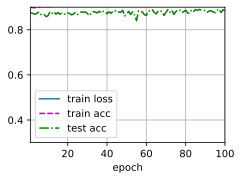

In [144]:
num_epochs = 100
mu.train_ch3(net, train_iter, test_iter, loss, num_epochs, optimiser)

* The minimal difference between the training and test accuracy shows that the model is not overfitting on the training data and is generalising well on the test data.

In [145]:
evaluate_accuracy(net, train_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.92445

In [146]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.8846